In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import random
import keras
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import Conv2D,SeparableConv2D,Dense,Input,Flatten,MaxPooling2D,AveragePooling2D,Activation
from keras.layers import Concatenate,Add,Multiply,Lambda
from keras.layers import BatchNormalization,Dropout
from keras.models import Model,Sequential
from matplotlib.image import imread
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from shufflenetv2 import ShuffleNetV2
from keras import optimizers
import keras.applications
from keras.utils import multi_gpu_model
from keras import backend as K
from keras import regularizers
import scipy
from pet_data import load_data,data_augment,show_data,show_false_pics

In [5]:
input_H = 224
input_W = 224
input_C = 3
input_shape = (input_H, input_W, input_C)
output_num = 2

## Load Raw Data

In [6]:
#Load 50% training data and 30% testing data
(x_train,y_train),(x_test,y_test) = load_data(0.7, 0.3)
print('done')

NameError: name 'ROOT' is not defined

## Visualize data

total training examples  2576
total testing examples  1100
x_train shape (2576, 224, 224, 3)
x_test shape (1100, 224, 224, 3)
y_train shape (2576, 2)
y_test shape (1100, 2)
A cat


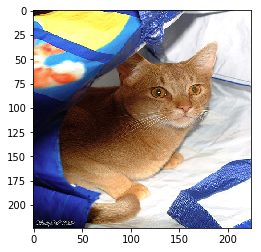

A cat


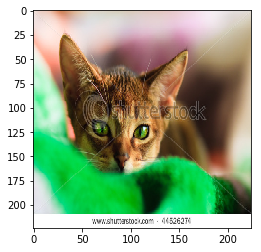

A cat


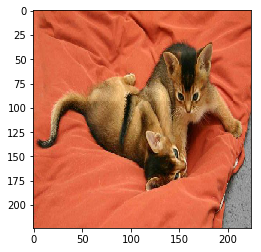

In [4]:
batch_size = 16
print('total training examples ',x_train.shape[0])
print('total testing examples ',x_test.shape[0])
print('x_train shape',x_train.shape)
print('x_test shape',x_test.shape)
print('y_train shape',y_train.shape)
print('y_test shape',y_test.shape)
show_data(x_train,y_train,[0,1,4])

In [15]:
def build_simple_densenet():
    'for training set size = 4 can achieve training accuracy 1 under [200epochs 2batch_size  mse sgd] '
    'sigmoid: loss '
    x = Sequential() 
    x.add(Conv2D(3,(3,3),padding='same',strides=(2,2),data_format='channels_last',input_shape=(input_H,input_W,input_C)))
    x.add(Activation('tanh'))
    x.add(Flatten())
    x.add(Dense(3000,activation= 'tanh'))
    x.add(Dense(1000,activation= 'tanh'))
    x.add(Dense(500,activation= 'tanh'))
    x.add(Dense(40,activation= 'tanh'))
    x.add(Dense(2,activation= 'softmax'))
    return 'simple_densenet',x

def build_simple_convnet():
    x = Sequential()
    activation = 'relu'
    #l2_reg = kernel_regularizer=regularizers.l2(0.01)
    l2_reg = regularizers.l2(5e-4)
    x.add(Conv2D(32,(3,3),padding='same',strides=(1,1),data_format='channels_last',input_shape=(input_H,input_W,input_C)))
    x.add(Conv2D(64,(3,3),padding='same',strides=(1,1),kernel_regularizer=l2_reg,data_format='channels_last'))
    x.add(MaxPooling2D(strides=2,data_format='channels_last'))
    x.add(Activation(activation))
    x.add(Conv2D(128,  3,padding='same',strides=1,kernel_regularizer=l2_reg,data_format='channels_last'))
    x.add(Conv2D(128,  3,padding='same',strides=1,kernel_regularizer=l2_reg,data_format='channels_last'))
    x.add(MaxPooling2D(strides=2,data_format='channels_last'))
    x.add(Activation(activation))
    x.add(Conv2D(256,  3,padding='same',strides=2,kernel_regularizer=l2_reg,data_format='channels_last'))
    x.add(Conv2D(256,  3,padding='same',strides=1,kernel_regularizer=l2_reg,data_format='channels_last'))
    x.add(MaxPooling2D(strides=2,data_format='channels_last'))
    x.add(Activation(activation))
    x.add(Flatten())
    x.add(Dropout(0.5))
    x.add(Dense(1024,activation=activation))
    x.add(Dropout(0.5))
    x.add(Dense(2,activation=activation))
    x.add(Activation('softmax'))
    return 'simple_convnet',x

def build_mimic_mobilenet():
    inputs = Input(shape=(input_H,input_W,input_C))
    x = BasicConv(inputs,32,3,2)
    x = BasicSepConv(x,32,3,1)
    x = BasicConv(x,64,1,1)
    x = BasicSepConv(x,64,3,2)
    x = BasicConv(x,128,1)
    x = BasicSepConv(x,128,3)
    x = BasicConv(x,128,1)
    x = BasicSepConv(x,256,3)
    x = BasicConv(x,256,1)
    x = BasicSepConv(x,256,3,2)
    x = BasicConv(x,512,1)
    for i in range(0,5):
        x = BasicSepConv(x,512,3)
        x = BasicConv(x,512,1)
    x = BasicSepConv(x,512,3,2)
    x = BasicConv(x,1024,1)
    x = BasicSepConv(x,1024,3,2)
    x = BasicConv(x,1024,1)
    x = AveragePooling2D(3)(x)
    x = Flatten()(x)
    x = Dense(2,activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    return 'mimic_mobilenet',model

def build_simple_rfbnet():
    inputs = Input(shape=(input_H,input_W,input_C))
    x = BasicConv(inputs,32,3,2)
    x = BasicRFB(x,64,2)
    x = BasicRFB(x,256)
    for  i in range(0,3):
        x = BasicRFB_a(x,256,2)
    x = BasicFC(x,output_num)
    model = Model(inputs=inputs, outputs=x)
    return  'simple_rfbnet',model
def build_mobilenet_v2():
    inputs = Input(shape=(input_H,input_W,input_C))
    base_model = keras.applications.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, depth_multiplier=1, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
    out = base_model.output
    out = Dense(output_num, activation= 'softmax')(out)
    model = Model(inputs=base_model.input, outputs=out)
    return 'mobilenet_v2',model

def build_shufflenet_v2():
    inputs = Input(shape=(input_H,input_W,input_C))
    base_model = ShuffleNetV2()
    out = base_model.output
    out = Dense(output_num, activation= 'softmax')(out)
    model = Model(inputs=base_model.input, outputs=out)  
    return 'shufflenet_v2',model
#multi_gpu_model(model, gpus=1, cpu_merge=True, cpu_relocation=False)


In [27]:
def fit_generator(model,x_train,y_train):
    (train_flow,val_flow) = data_augment(x_train,y_train,batch_size)
    history = model.fit_generator(train_flow,steps_per_epoch=len(x_train)/batch_size,validation_data=val_flow,validation_steps=300,epochs=epochs_per_stage)
    return history
def plot_training(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## Set training params

In [33]:
phase = 'training'
epochs_per_stage = 10
stages = 20
load_weights = True
check_point = 8
clear_session = True
build_model = build_shufflenet_v2
lr=5e-4
decay=1e-7
momentum=0.9
#model.load_weights(model_name + ".h5")
# Plot training & validation loss values

## Build model

In [34]:
if clear_session:
    K.clear_session()
model_name,model=build_model()
model.compile(optimizer=optimizers.SGD(lr=lr,decay=decay,momentum=momentum),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print('model:',model_name,'has been built')

model: shufflenet_v2 has been built


## Load weights

In [35]:
if load_weights:
    print("load weights from check point",check_point)
    model.load_weights(model_name + '_' + str(check_point) + ".h5")
else:
    assert(check_point==0)

load weights from check point 8


## Training or testing

In [36]:
if phase == 'training':
    print('start fitting..')
    for i in range(1,stages):
        #history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs_per_stage, verbose = 1, validation_split = 0.25)
        print("stage ",i,"of ",stages)
        fit_generator(model,x_train,y_train)
        save_path = "saved_weights/" + model_name + '_' + str(i + check_point) + ".h5"
        print("save at",save_path)
        model.save_weights(save_path)
elif phase =='testing':
    result = model.evaluate(x=x_test,y=y_test)
    print('loss',round(result[0],5),'accuracy:',round(result[1],5))
    model.save_weights(model_name + ".h5")


start fitting..
Epoch 1/10
161/161 [==============================] - 32s 196ms/step - loss: 0.5730 - acc: 0.6840 - val_loss: 0.6221 - val_acc: 0.6866
Epoch 2/10
161/161 [==============================] - 26s 160ms/step - loss: 0.5754 - acc: 0.6888 - val_loss: 0.6109 - val_acc: 0.6732
Epoch 3/10
161/161 [==============================] - 26s 160ms/step - loss: 0.5656 - acc: 0.6986 - val_loss: 0.6069 - val_acc: 0.6930
Epoch 4/10
161/161 [==============================] - 26s 161ms/step - loss: 0.5632 - acc: 0.7037 - val_loss: 0.6398 - val_acc: 0.6643
Epoch 5/10
161/161 [==============================] - 26s 162ms/step - loss: 0.5685 - acc: 0.7048 - val_loss: 0.6533 - val_acc: 0.6635
Epoch 6/10
161/161 [==============================] - 26s 161ms/step - loss: 0.5542 - acc: 0.7182 - val_loss: 0.6437 - val_acc: 0.6751
Epoch 7/10
161/161 [==============================] - 26s 159ms/step - loss: 0.5546 - acc: 0.7122 - val_loss: 0.6308 - val_acc: 0.6843
Epoch 8/10
161/161 [===================

Epoch 10/10
161/161 [==============================] - 26s 160ms/step - loss: 0.4656 - acc: 0.7908 - val_loss: 0.6075 - val_acc: 0.6849
save at saved_weights/shufflenet_v2_14.h5
Epoch 1/10
161/161 [==============================] - 27s 168ms/step - loss: 0.4845 - acc: 0.7707 - val_loss: 0.4472 - val_acc: 0.8070
Epoch 2/10
161/161 [==============================] - 26s 160ms/step - loss: 0.4678 - acc: 0.7904 - val_loss: 0.5580 - val_acc: 0.7048
Epoch 3/10
161/161 [==============================] - 26s 160ms/step - loss: 0.4622 - acc: 0.7900 - val_loss: 0.4940 - val_acc: 0.7600
Epoch 4/10
161/161 [==============================] - 26s 160ms/step - loss: 0.4601 - acc: 0.7952 - val_loss: 0.5358 - val_acc: 0.7579
Epoch 5/10
161/161 [==============================] - 26s 159ms/step - loss: 0.4556 - acc: 0.7939 - val_loss: 0.5391 - val_acc: 0.7534
Epoch 6/10
161/161 [==============================] - 26s 159ms/step - loss: 0.4705 - acc: 0.7805 - val_loss: 0.6041 - val_acc: 0.6274
Epoch 7/10
1

Epoch 9/10
161/161 [==============================] - 26s 161ms/step - loss: 0.2316 - acc: 0.9114 - val_loss: 0.2981 - val_acc: 0.8957
Epoch 10/10
161/161 [==============================] - 26s 162ms/step - loss: 0.2033 - acc: 0.9286 - val_loss: 0.4211 - val_acc: 0.8435
save at saved_weights/shufflenet_v2_20.h5
Epoch 1/10
161/161 [==============================] - 27s 168ms/step - loss: 0.2333 - acc: 0.9149 - val_loss: 0.2549 - val_acc: 0.9063
Epoch 2/10
161/161 [==============================] - 26s 162ms/step - loss: 0.2075 - acc: 0.9239 - val_loss: 0.3615 - val_acc: 0.8340
Epoch 3/10
161/161 [==============================] - 26s 161ms/step - loss: 0.1904 - acc: 0.9365 - val_loss: 0.2875 - val_acc: 0.8957
Epoch 7/10
161/161 [==============================] - 26s 159ms/step - loss: 0.1923 - acc: 0.9340 - val_loss: 0.4818 - val_acc: 0.8099
Epoch 8/10
161/161 [==============================] - 26s 161ms/step - loss: 0.1594 - acc: 0.9449 - val_loss: 0.3124 - val_acc: 0.8899
Epoch 9/10
1

MemoryError: 

In [ ]:
show_false_pics(model, x_test, y_test)